In [1]:
### Not to be included in the paper ###
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import sys
import cuqi
cuqi.__version__

'0+untagged.2381.gd0a98fd.dirty'

In [423]:
scale=1/1000**2; Ns=100000; Nb=10; decay_rate=0.5; sampler_meth=cuqi.sampler.MALA; sampler_args={'scale':scale}; exact_is_sample=True #1 MALA: some success, exact sol not within 95% CI, ESS is low
scale=1/100**2; Ns=1000; Nb=10; decay_rate=0.5; exact_is_sample=True #2 MALA: not very good, but tries to trace the exact solution
scale=1/200**2; Ns=1000; Nb=10; decay_rate=0.5; exact_is_sample=True #3 MALA: similar behaviour for 2
scale=1/150**2; Ns=1000; Nb=10; decay_rate=0.5; exact_is_sample=True #4 MALA: similar behaviour for 3
scale=1/200**2; Ns=10000; Nb=10; decay_rate=0.5; exact_is_sample=True #5 MALA: some success, exact sol not within 95% CI, ESS is low, but better than 3

scale=1/200**2; Ns=1000; Nb=10; decay_rate=0.5; sampler_meth=cuqi.sampler.CWMH; sampler_args={}; exact_is_sample=True #6 CWMH: Wayy better than all previous cases in terms of reconstruction and ESS, smallest ESS is ~8
scale=1/200**2; Ns=1000; Nb=10; decay_rate=0.5; sampler_meth=cuqi.sampler.CWMH; sampler_args={}; exact_is_sample=False #6 CWMH:reasonable reconstruction but CI is large, smallest ESS is ~8

scale=1/200**2; Ns=1000; Nb=10; decay_rate=0.5; sampler_meth=cuqi.sampler.MetropolisHastings; sampler_args={'scale':scale}; exact_is_sample=True #5 MetropolisHastings: Very bad, no exploration
scale=1/200**2; Ns=1000; Nb=10; decay_rate=0.5; sampler_meth=cuqi.sampler.pCN; sampler_args={'scale':scale}; exact_is_sample=True #7 pCN: very bad, no exploration
scale=1/200**2; Ns=1000; Nb=10; decay_rate=0.5; sampler_meth=cuqi.sampler.pCN; sampler_args={}; exact_is_sample=True #8 pCN: some success, exact sol not within 95% CI, ESS is low, but better than 3 

scale=1/200**2; Ns=10000; Nb=10; decay_rate=1.6; sampler_meth=cuqi.sampler.CWMH; sampler_args={}; exact_is_sample=True #9 very good
scale=1/200**2; Ns=10000; Nb=10; decay_rate=1.6; sampler_meth=cuqi.sampler.MALA; sampler_args={'scale':scale}; exact_is_sample=True #10, okay
scale=1/200**2; Ns=10000; Nb=10; decay_rate=1.6; sampler_meth=cuqi.sampler.ULA; sampler_args={'scale':scale}; exact_is_sample=True #11, okay, seems better than MALA

scale=1/200**2; Ns=10000; Nb=10; decay_rate=1.6; sampler_meth=cuqi.sampler.ULA; sampler_args={'scale':scale}; exact_is_sample=False #12, did not work

scale=1/200**2; Ns=10000; Nb=10; decay_rate=1.6; sampler_meth=cuqi.sampler.CWMH; sampler_args={}; exact_is_sample=False #13

# CUQIpy example: 1D Heat problem

Here we go through the steps of creating a time dependant PDE-based Bayesian inverse problem within the CUQIpy library. The forward model we consider is a one dimensional (1D) time-dependent heat model with zero boundary conditions.

\begin{align}
\frac{\partial u(x,t)}{\partial t} - c^2 \frac{\partial^2 u(x,t)}{\partial x^2}   & = f(x,t), \;x\in[0,L],\; 0\le t \le T\\
u(0,t)= u(L,t)&= 0\\
u(x,0)&= g(x) 
\end{align}


where $u(x,t)$ is the temperature and $c^2$ is the thermal diffusivity (assumed to be 1 here). We assume the source term $f$ is zero. The unknown Bayesian parameters for this test problem is the initial heat profile $\theta(x):=g(x)$.

The data we obtain for this problem is the temperature measurements everywhere in the domain at the final time $T$. We assume that the measurement error $\eta$ follows a Gaussian distribution. In a Bayesian setting, we can represent the data as a random variable $y$:

\begin{align}
y = \mathcal{G}(\theta) + \eta, \;\;\; \eta\sim\mathcal{N}(0,\sigma_\text{noise}^2\mathbf{I}),
\end{align}

where $\mathcal{G}(\theta)$ is the forward model that maps the initial condition $\theta$ to the final time solution $u(x,T)$ via solving the 1D time-dependent heat problem. For this test case, $T=0.01$, $L=1$, relative noise level is $0.01$, and the number of grid nodes for the finite difference discretization is $100$.

In the remaining of this section, we create and solve the Bayesian problem which is the task of inferring the posterior distribution of the initial heat profile $\theta(x)$ given observed data $y_\text{obs}$.

### 1. Create the PDE problem

In [424]:
### Not to be included in the paper ###

# Prepare PDE form
N = 50   # Number of solution nodes
L = 1.0  # Length of the domain
T = 0.01 # Final time
dx = L/(N+1)   # Space step size
cfl = 5/11 # The cfl condition to have a stable solution
dt_approx = cfl*dx**2 # Defining approximate time step size
num_time_steps = int(T/dt_approx)+1 # Number of time steps

Here we create the building blocks that we need to define the 1D time-dependant heat PDE. We choose the number of solution nodes `N`, the domain length `L`, the final time `T`, and number of time steps `num_time_steps` to be 80, 1.0, 0.03, 434, respectively. Then we define three python objects: a `numpy.ndarray` representing the spatial grid `grid`, a `numpy.ndarray` array representing the time steps `time_steps` and a `numpy.ndarray` representing the discretized diffusion differential operator using centered difference. 

In [425]:
# Grid for the heat model
grid = np.linspace(dx, L, N, endpoint=False)

# Time steps
time_steps = np.linspace(0, T, num_time_steps, endpoint=True)

# PDE form (diff_op, IC, time_steps)
Dxx = (np.diag( -2*np.ones(N) ) + np.diag(np.ones(N-1),-1) + np.diag(np.ones(N-1),1))/dx**2 # FD diffusion operator

### 2. Create `cuqi.pde.TimeDependentLinearPDE` object

The details of the PDE problem is encapsulated in a `cuqi.pde.PDE` object. For this time-dependent problem we create `cuqi.pde.TimeDependentLinearPDE` object. This object needs information about the grid `grid` and the time stepping `time_steps` and a representation of the PDE at a given time `t`. This representation is a python function that accepts as a first argument an instance of the Bayesian parameter, the `initial_condition` here, and the time `t` as a second argument. It returns a tuple of the differential operator at time `t`, the right hand side at time `t` and the initial condition. One can also specify the time discretization scheme to be implicit or explicit euler, in addition to other arguments that are accepted by parent classes `cuqi.pde.LinearPDE` and `cuqi.pde.PDE`.

In [426]:
def PDE_form(initial_condition, t): return (Dxx, np.zeros(N), initial_condition)

PDE = cuqi.pde.TimeDependentLinearPDE(
    PDE_form, time_steps, grid_sol=grid)

### 3. Create the forward model

Next we create the `cuqipy` forward model. In this case we create a `cuqi.model.PDEModel` which is a subclass of `cuqi.model.Model`. To initialize an object of this class, we pass a `cuqi.pde.PDE` along with two `cuqi.geometry.Geometry` objects to represent the domain and the range of the forward PDE problem. `cuqi.model.PDEModel` is agnostic to the underlying details of the PDE. It interact with the `PDE` object through the functions `assemble`, `solve`, and `observe`. The underlying `PDE` object might be representing, for example, a time-dependent PDE problem discretized using finite difference method or a steady state PDE problem discretized using finite element method.

The domain geometry represents the domain of the forward problem, the function space of the discretized $g(x)$ in this case. To impose some regularity on the initial condition $g(x)$, we parametrize it using Karhunen–Loève (KL) expansion. This will represent the inferred heat initial profile as a linear combination of sine functions and a constant. 

$$g(x_j) = u(x_j,0) = \sum_{i=0}^{N-2} \left(\frac{1}{(i+1)^\gamma\tau}\right)  \theta_i \, \text{sin}\left(\frac{\pi}{N}(i+1)(j+\frac{1}{2})\right) + \frac{(-1)^j}{2}\left(\frac{1}{N^\gamma\tau}\right)  \theta_{N-1}$$

    
where $x_j$ is the $j^\text{th}$ grid point (in a regular grid), $j=0, 1, 2, 3, ..., N-1$, $N$ is the number of nodes in the grid, $\gamma$ is the decay rate, $\tau$ is a normalization constant, and $\theta_i$ are the expansion coefficients. We note that using the KL-expansion parameterization, the Bayesian parameters are the coefficients of expansion $\theta_i$. We set up the domain geometry as a `cuqi.geometry.KLExpansion` object and pass the arguments `decay_rate=1.7` and `normalizer=12` for the decay rate and the normalization constants, respectively.

The range geometry represents the function space of the observed data, $u(0,T)$ in this case, which can be represented by a `cuqi.geometry.Continuous1D` object.

In [427]:
# Set up geometries for model
domain_geometry = cuqi.geometry.KLExpansion(grid, decay_rate=decay_rate, normalizer=12, num_modes=10) #1.6



#std = 1.2
#cor_len = .1
#nu = 3.0
#domain_geometry = cuqi.geometry.KLExpansion_Full(grid,std,cor_len,nu)


range_geometry = cuqi.geometry.Continuous1D(grid)

# Prepare model
model = cuqi.model.PDEModel(PDE,range_geometry,domain_geometry)

In [428]:
def g( dir, x):
    x_np = np.empty(x.shape)
    x_np[:] = x

    dir_np = np.empty(dir.shape)
    dir_np[:] = dir
    
    return cuqi.utilities.approx_derivative(model, x_np, dir_np)

#model._gradient_func = g

### 4. Create the Bayesian model

After constructing the forward model, we want to set up the Bayesian model, i.e. the posterior distribution. In `CUQIpy` we achieve this by creating a joint distribution on the Bayesian parameters $\theta$ and the data $y$ using the `JointDistribution` class and then condition it on a synthesized data that we create for this test case. The joint distribution is given by:

\begin{align}
p(\theta,y) = p(y|\theta)p(\theta)
\end{align}
where $p(x)$ is the prior probability density function (PDF) and $p(y|\theta)$ is the data distribution PDF.

We start by defining the prior distribution $p(\theta)$ as a standard multivariate Gaussian distribution $\mathcal{N}(\mathbf{0}, \mathbf{I})$ using `cuqi.distribution.GaussianCov` class. We pass the keyword argument `geometry=domain_geometry` when initializing this distribution so that the distribution encapsulates the knowledge that the multivariate random variable $\theta$ represents the expansion coefficient in the KL expansion (<equation_number>).

In [429]:
# Create the prior distribution 
x = cuqi.distribution.Gaussian(np.zeros(model.domain_dim), cov=1, geometry=domain_geometry)

Now samples from the prior will look like:

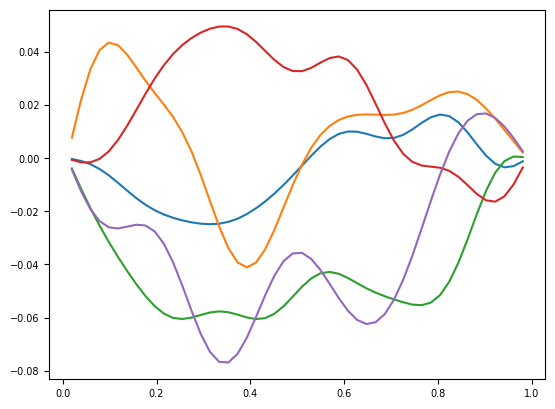

In [430]:
### Not to be included in the paper ###
for i in range(5):
    x.sample().plot()

For this test case, we assume that the true initial heat profile is given by the expression

\begin{align}
g_\text{exact}(x) = e^{-2x} \sin(L-x)
\end{align}

We create `cuqi.samples.CUQIarray` object representing this signal and we call it `theta_true`. We apply the forward model on `theta_exact` to obtain what we call exact data `y_exact`, which is the outcome of the forward model that is not corrupted by measurement noise. 

In [431]:
### Not to be included in the paper ###

# True parameters that we want to infer
if not exact_is_sample:
    x_exact_raw = grid*np.exp(-2*grid)*np.sin(L-grid)
    x_exact = cuqi.samples.CUQIarray(x_exact_raw, is_par=False, geometry=domain_geometry)
else:
    np.random.seed(0)
    x_exact = x.sample()

In [432]:
# Generate the exact data
y_exact = model.forward(x_exact)

* explain data distribution (1 lines of code) + how we calculated sigma
* explain generating data (1 line of code)

We then create the data distribution `y` as a `cuqi.distribution.GaussianCov` object with the mean being the forward model applied to the Bayesian parameter $\theta$ `model(x)` and covariance matrix given by $\sigma^2\mathbf{I}_M$ where $\sigma= \frac{0.01}{\sqrt{N}} ||\mathcal{G}(g_\text{exact}(x))||$ and $\mathbf{I}_M$ is the $M$ dimensional identity matrix. We also equip the data distribution with the range geometry `range_geometry`.

In [433]:
### Not to be included in the paper ###
noise_level = 0.01 #0.01 #0.03 # 0.05
sigma =1.0/np.sqrt(N)* noise_level*np.linalg.norm(y_exact)

In [434]:
# Create the data distribution 
y = cuqi.distribution.Gaussian(model(x), cov=sigma**2*np.eye(model.range_dim), geometry=range_geometry)

An instance of the noisy data (`data`) can then be simply generated as a sample of the distribution `y` conditioned on `x=x_exact`. Figure <fig_num> shows the exact solution $g(x)$, and the exact and the noisy data.

In [435]:
# Generate noisy data
data = y(x = x_exact).sample()

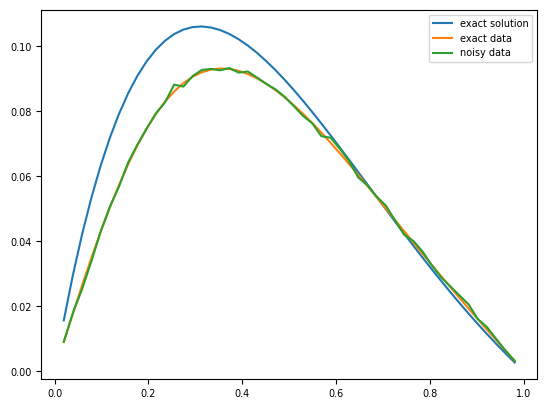

In [436]:
### Not to be included in the paper ###

x_exact.plot()
y_exact.plot()
data.plot()
plt.legend(['exact solution', 'exact data', 'noisy data']);

In [437]:
### Not to be included in the paper ###

#plt.plot(data-y_exact)
print(np.linalg.norm(data-y_exact))
print(np.linalg.norm(y_exact))
print(np.linalg.norm(data-y_exact)/np.linalg.norm(y_exact))


0.004917420587378931
0.4517183337286459
0.010886032777967566


Now that we have the distributions `x` and `y`, we can create the joint distribution $p(x,y)$. Conditioning the joint distribution on `y=data` gives the posterior distribution. 

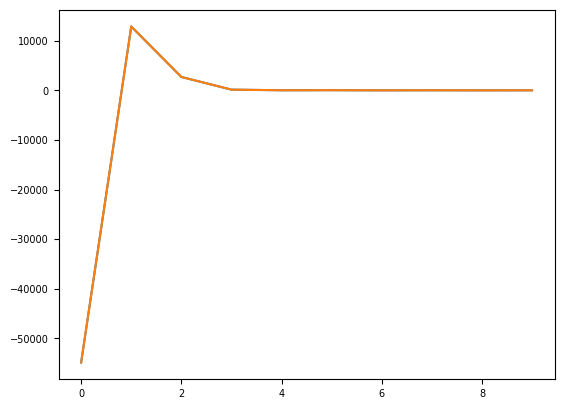

In [438]:
# Bayesian model
joint_distribution = cuqi.distribution.JointDistribution(x, y)
posterior = joint_distribution(y = data) 
posterior.use_FD = True

sample = x.sample()
sample_nd = np.ndarray(sample.shape)
sample_nd[:] = sample
plt.plot(posterior.gradient(sample))
plt.plot(cuqi.utilities.approx_derivative(posterior.logpdf, sample_nd))

### 5. Estimate the Bayesian solution

Solving the Bayesian problem amounts to characterizing the posterior distribution. In `CUQIpy` we use MCMC sampling methods to approximate the posterior and compute its moments. For this test case we use component wise Metropolis Hastings algorithm. We create the sampler, which takes the `posterior` as an argument in the initialization, and then generates 4000 samples. The `CWMH` method `sample_adapt` adjusts the scale of the algorithm (the step size) to achieve a target acceptance rate of about $0.23$. 

In [439]:
MySampler = sampler_meth(posterior, **sampler_args)  #cuqi.sampler.MALA(posterior, scale = scale)
posterior_samples = MySampler.sample_adapt(Ns,Nb) # 10000


Sample 10010 / 10010

Average acceptance rate all components: 0.38607 



In [440]:
print(MySampler)
print(Ns)
print(Nb)

10000
10


We use samples visualization and postprocessing methods to obtain the credible interval. In figure <ci_fig1> we show the cridible interval computed on the coefficient space then transformed to the function space, whereas in Figure <ci_fig2> we transform the samples to the function space first, then compute the credible interval. The later case can be achieved easily by applying `plot_ci` on the `Samples` property `funvals`, which in turns return a `Samples` object which contains the function values of the samples. 

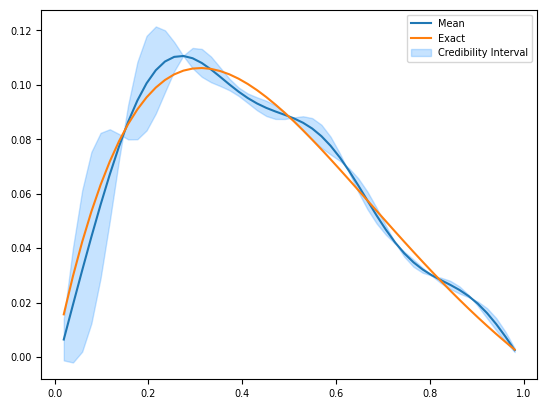

In [441]:
posterior_samples.plot_ci(95, exact=x_exact)

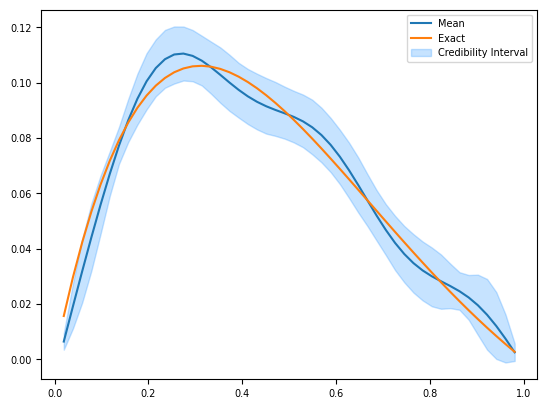

In [442]:
posterior_samples.funvals.plot_ci(95, exact=x_exact)

NotImplementedError: fun2par not implemented. 

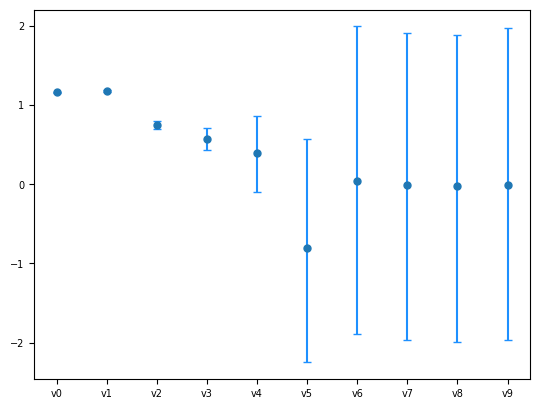

In [443]:
posterior_samples.plot_ci(95, plot_par=True, exact=x_exact)

array([4.00000000e+04, 4.00940554e+02, 6.67983914e+01, 2.31769992e+00,
       1.33639293e+00, 5.71409315e+00, 1.47754149e+00, 2.20420389e+00,
       3.39589204e+00, 1.34659586e+00])

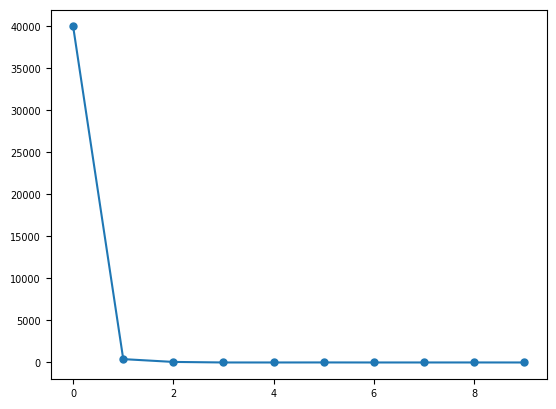

In [ ]:
plt.plot(posterior_samples.compute_ess(), 'o-')
posterior_samples.compute_ess()

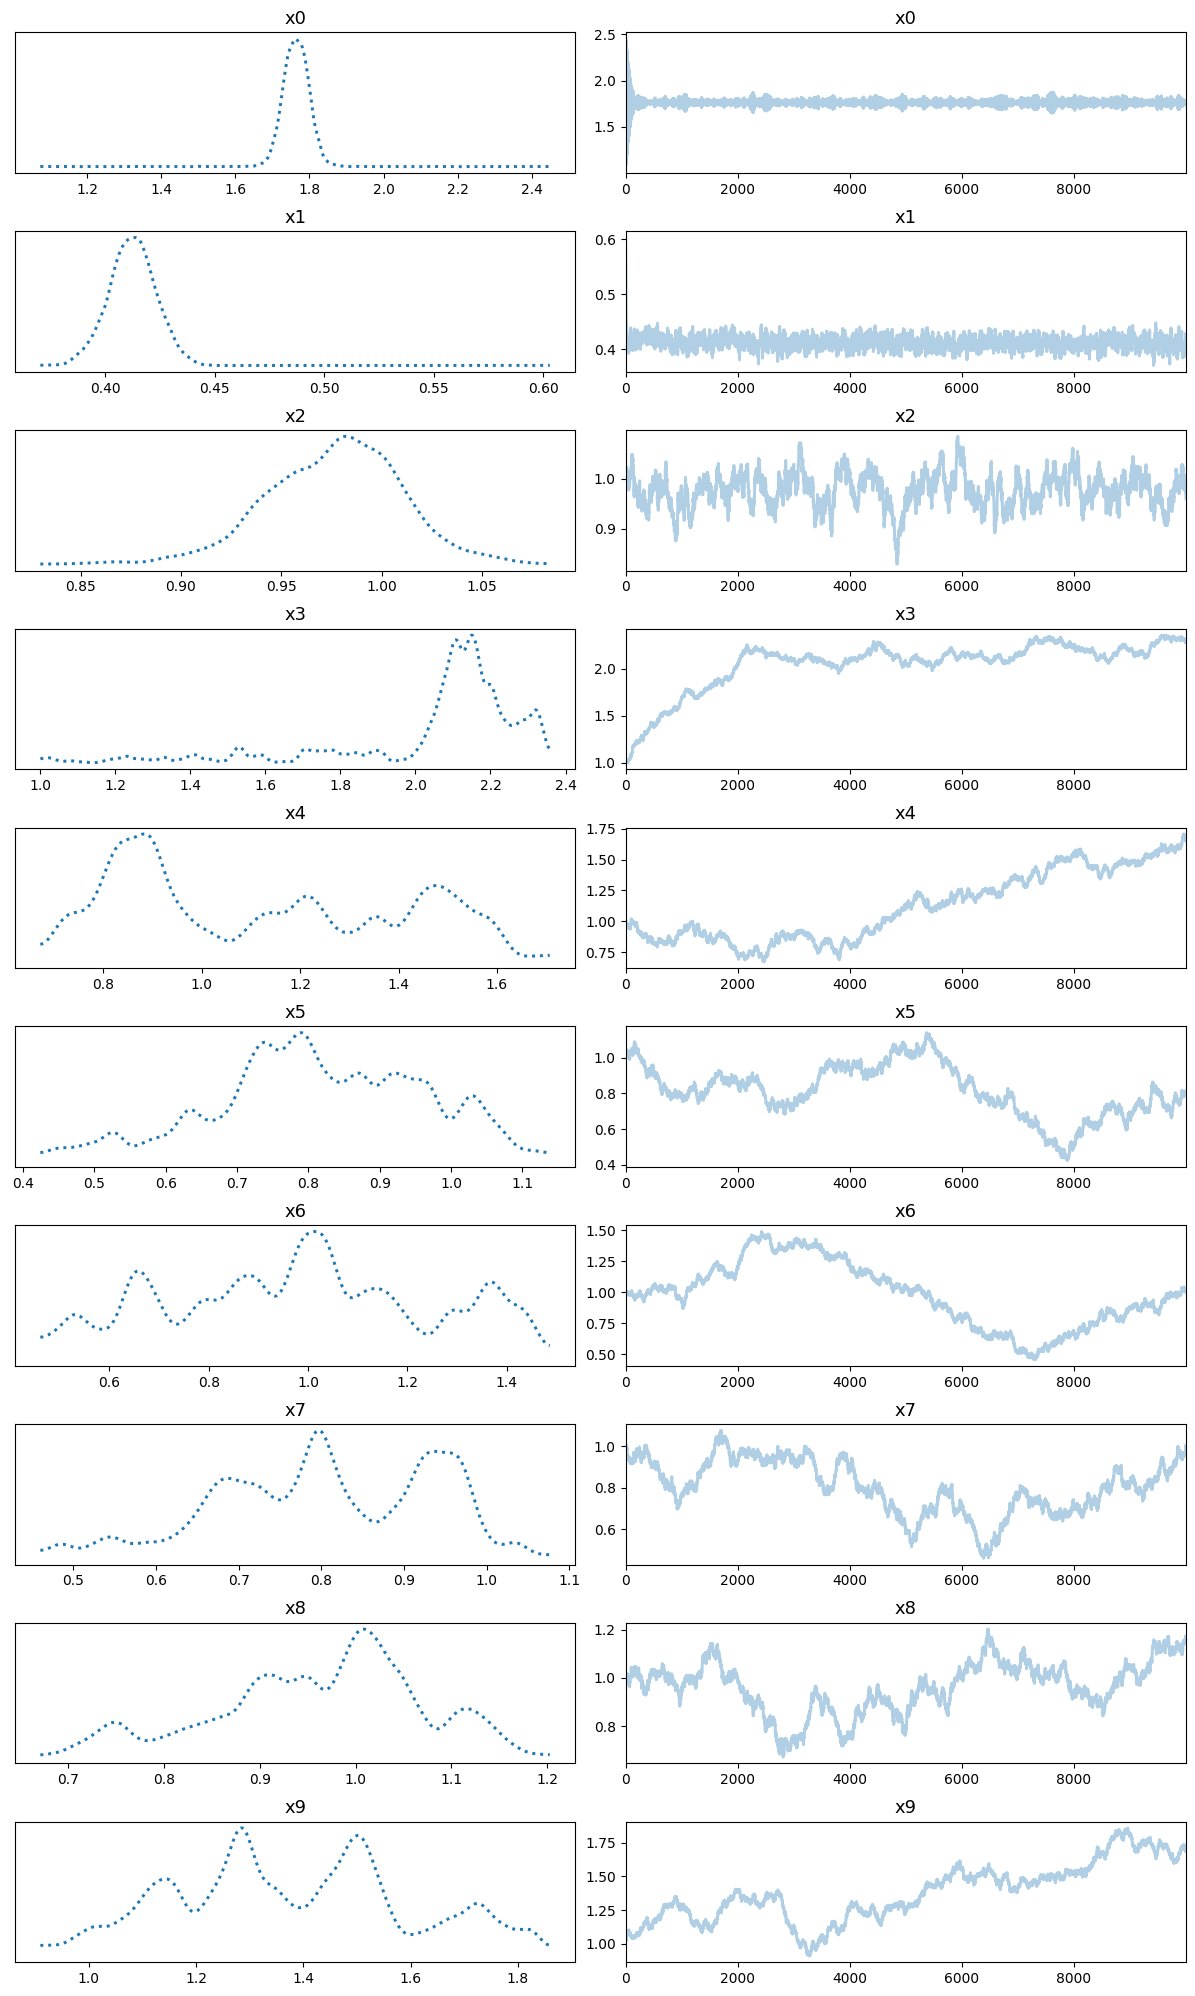

In [ ]:
posterior_samples.plot_trace([0,1,2,3,4,5,6,7,8,9]);

|

|

|

|

|

|

|

|

|

|


# Notes:
* Partial observation 
* Change end point to L
* Enforce positivity 
* Change x to theta
* Fix the noise level
* Try the heavy-side after fixing the noise.
* Combine pCN with CWMH (each good at different modes)
* Reduce the number of nodes
* MAP point 
* hierarchical model for estimating regularity of the heat problem

In [ ]:
# Sample using pCN sampler

pcn_sampler = cuqi.sampler.pCN(posterior)
pcn_samples = pcn_sampler.sample_adapt(100000) # 100000

#pcn_sampler = cuqi.sampler.MALA(posterior, scale = scale)
#pcn_samples = pcn_sampler.sample_adapt(10000) # 100000

Sample 10000 / 10000


array([4.75082832e+03, 2.55009666e+02, 3.10607869e+01, 6.28058401e+00,
       1.33505114e+00, 1.33801962e+00, 2.29877200e+00, 1.79186788e+00,
       1.54890000e+00, 1.30857808e+00])

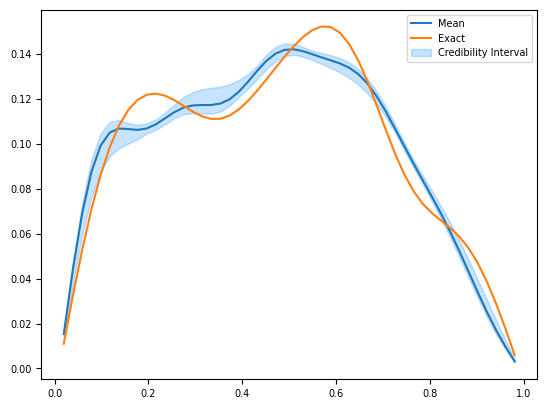

<Figure size 640x480 with 0 Axes>

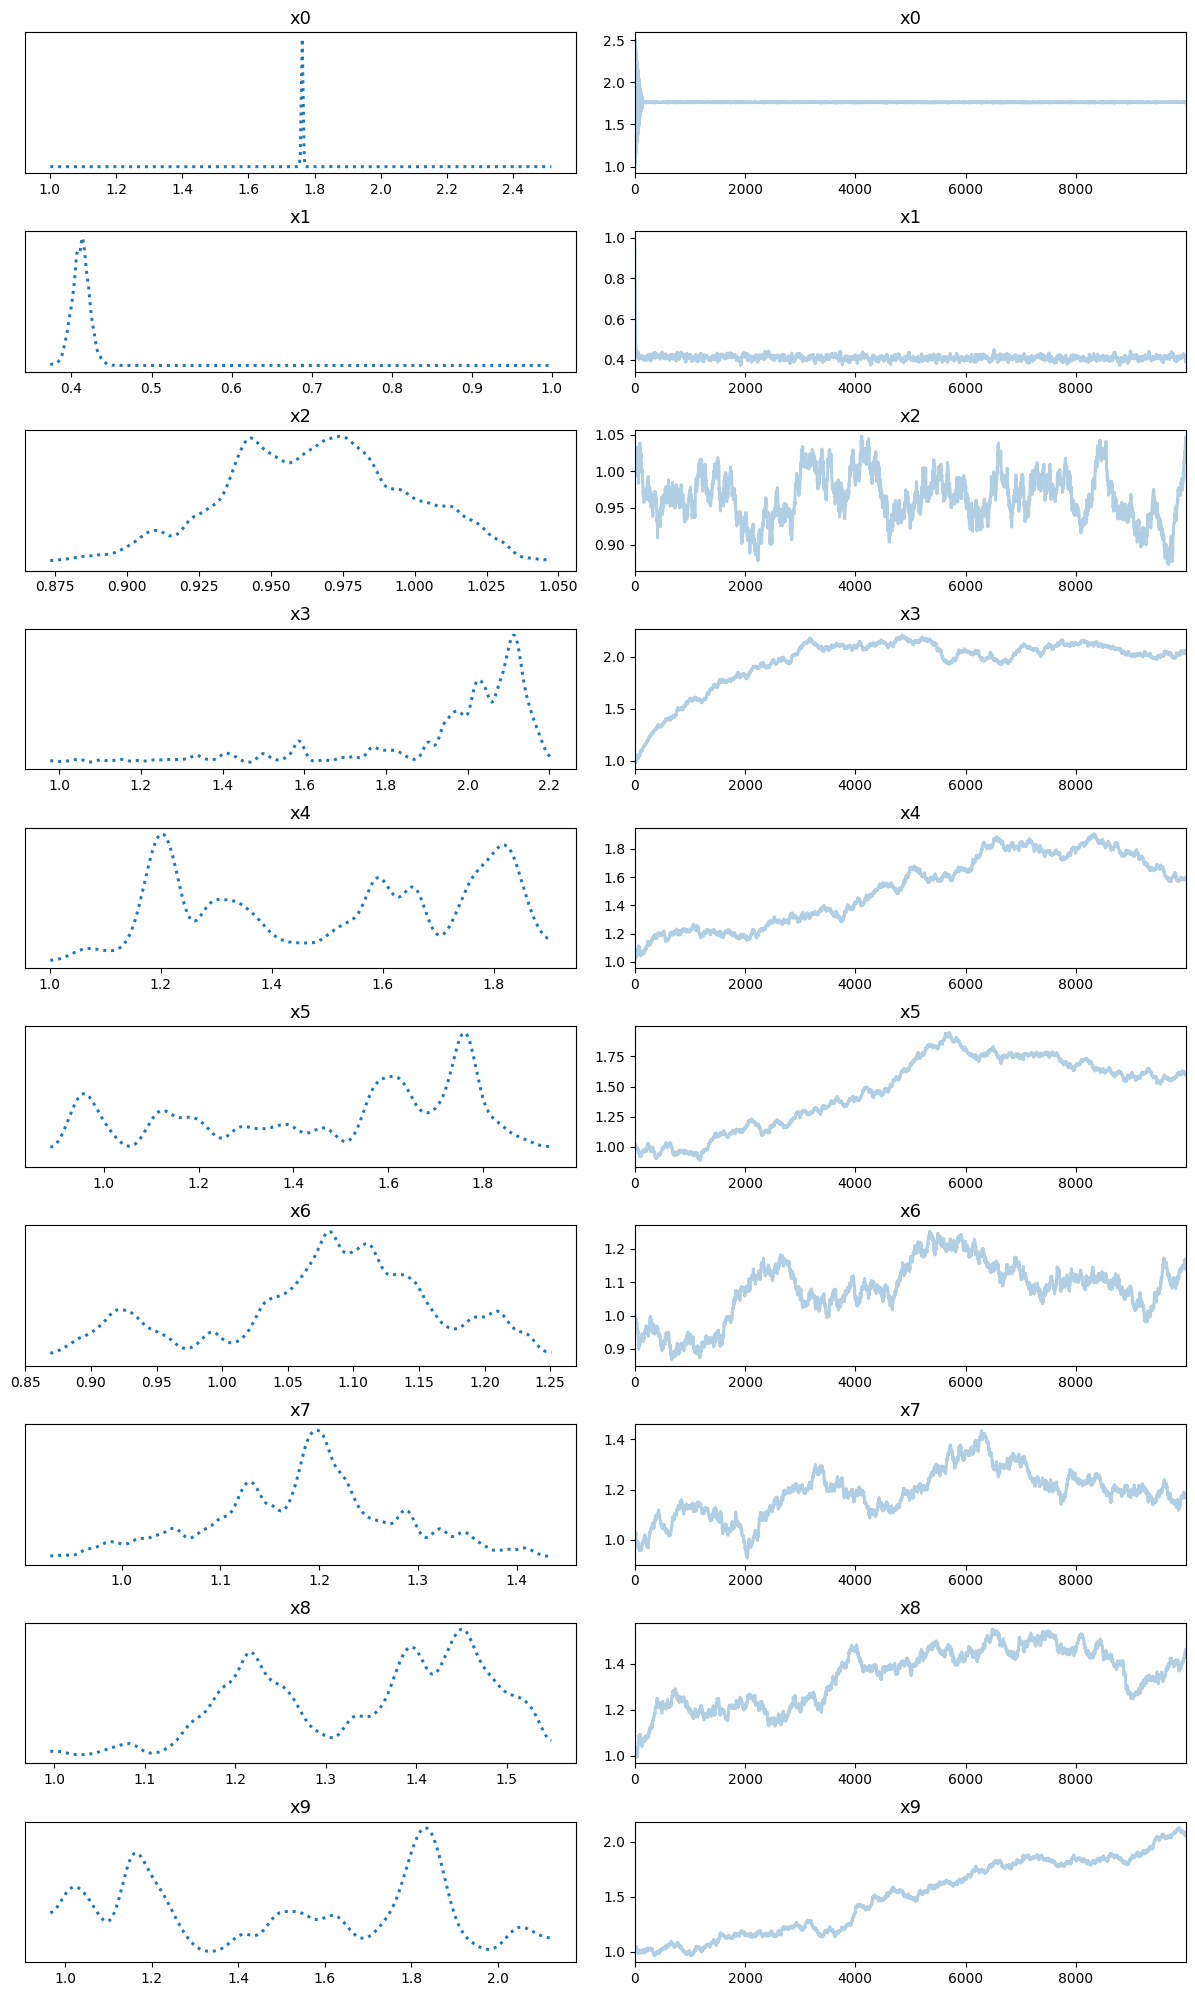

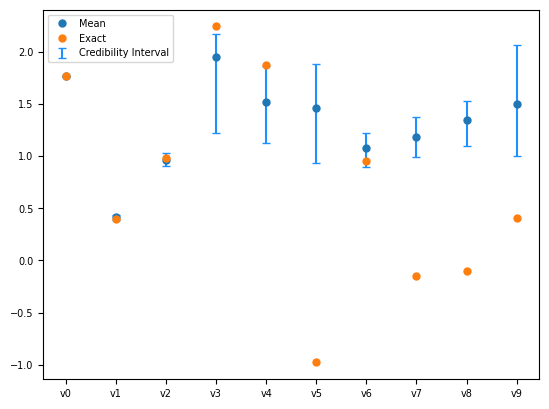

In [ ]:
# Visualize/Analyze pCN samples
pcn_samples.burnthin(0).funvals.plot_ci(95, exact=x_exact)
plt.figure()
pcn_samples.plot_trace([0,1,2,3,4,5,6,7,8,9])
plt.figure()
pcn_samples.plot_ci(plot_par=True, exact=x_exact)
pcn_samples.compute_ess()

In [ ]:
# Create samples object that combines 2 samplers results
combined_samples = cuqi.samples.Samples(np.hstack([posterior_samples.samples,pcn_samples.samples]), geometry=domain_geometry)

 None,
 <ErrorbarContainer object of 3 artists>]

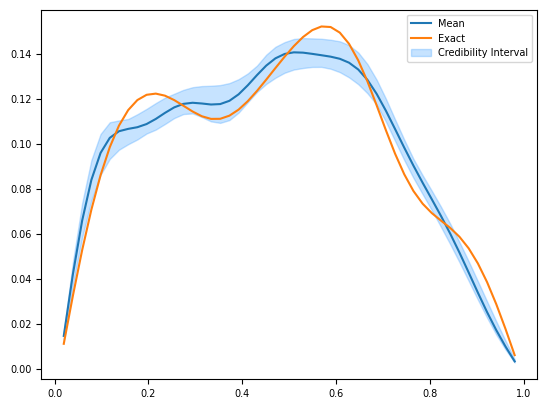

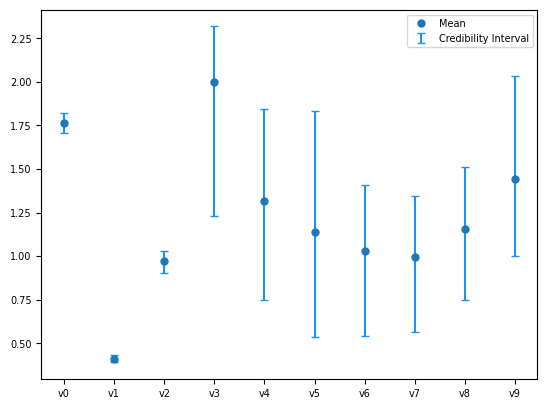

In [ ]:
# Visualize/Analyze the combined samples
combined_samples.funvals.plot_ci(95, exact=x_exact)
plt.figure()
combined_samples.plot_ci(plot_par=True)

array([[<AxesSubplot: ylabel='x1'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='x2'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='x3'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='x0', ylabel='x4'>,
        <AxesSubplot: xlabel='x1'>, <AxesSubplot: xlabel='x2'>,
        <AxesSubplot: xlabel='x3'>]], dtype=object)

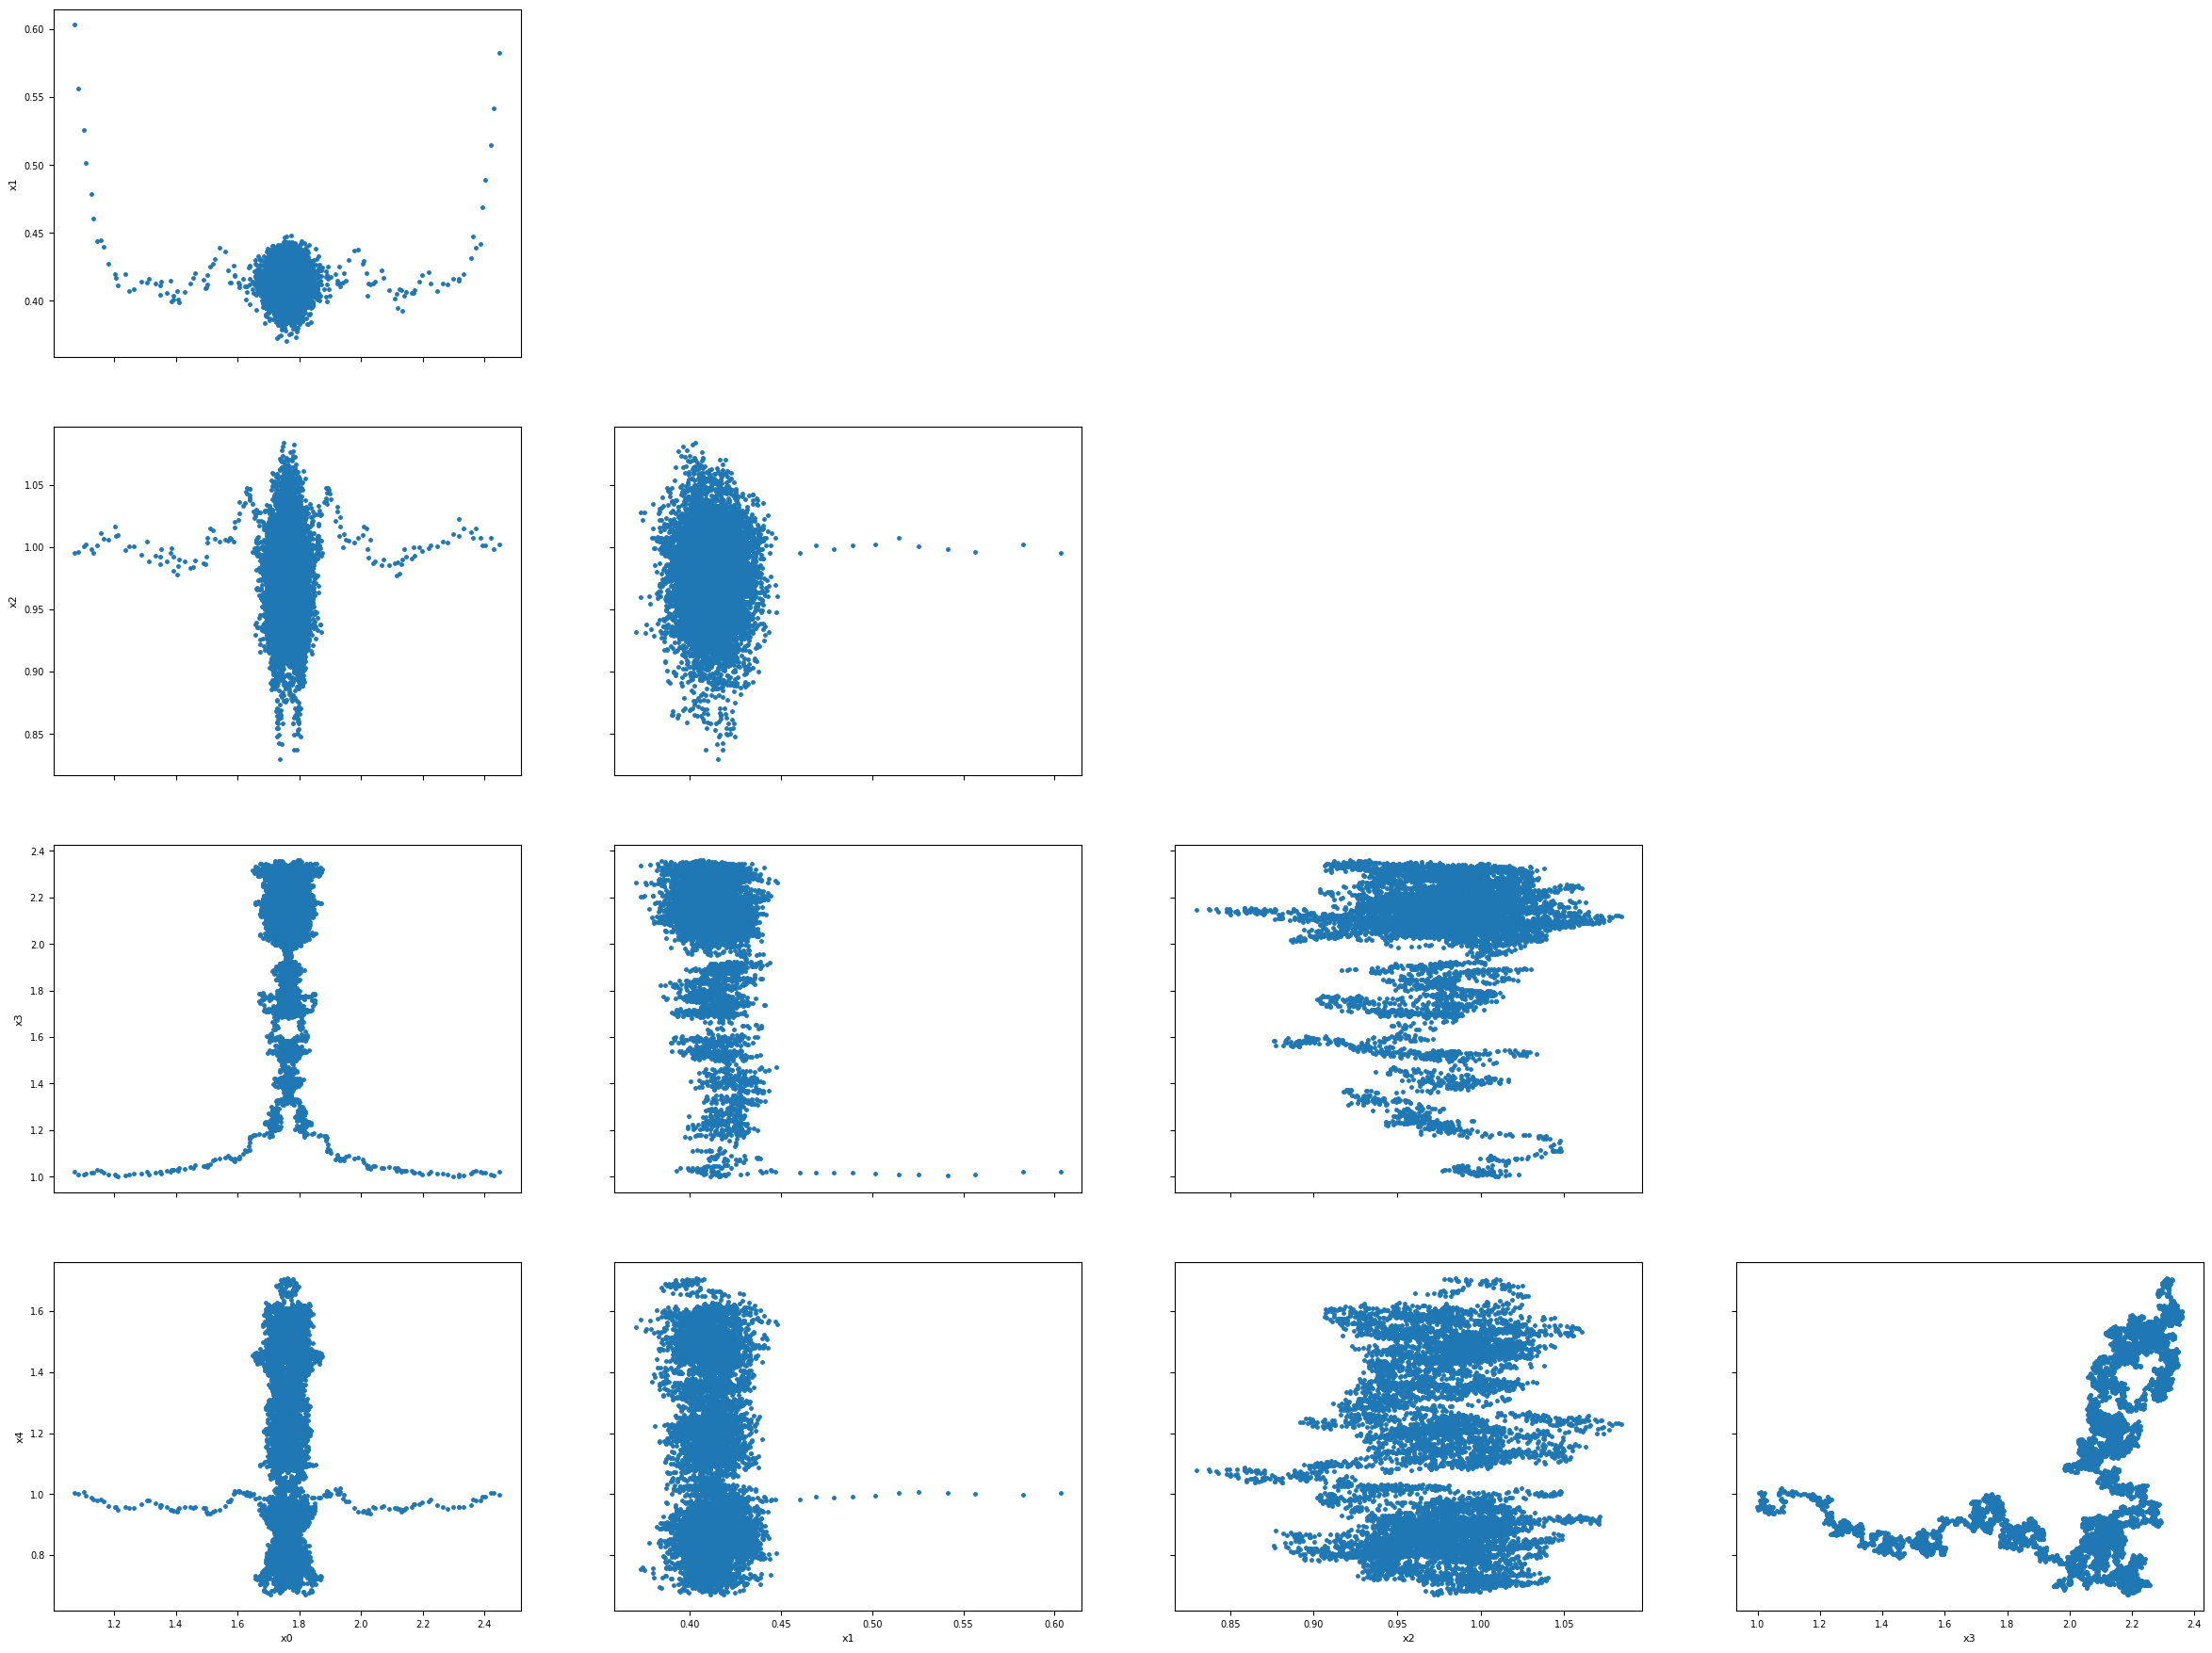

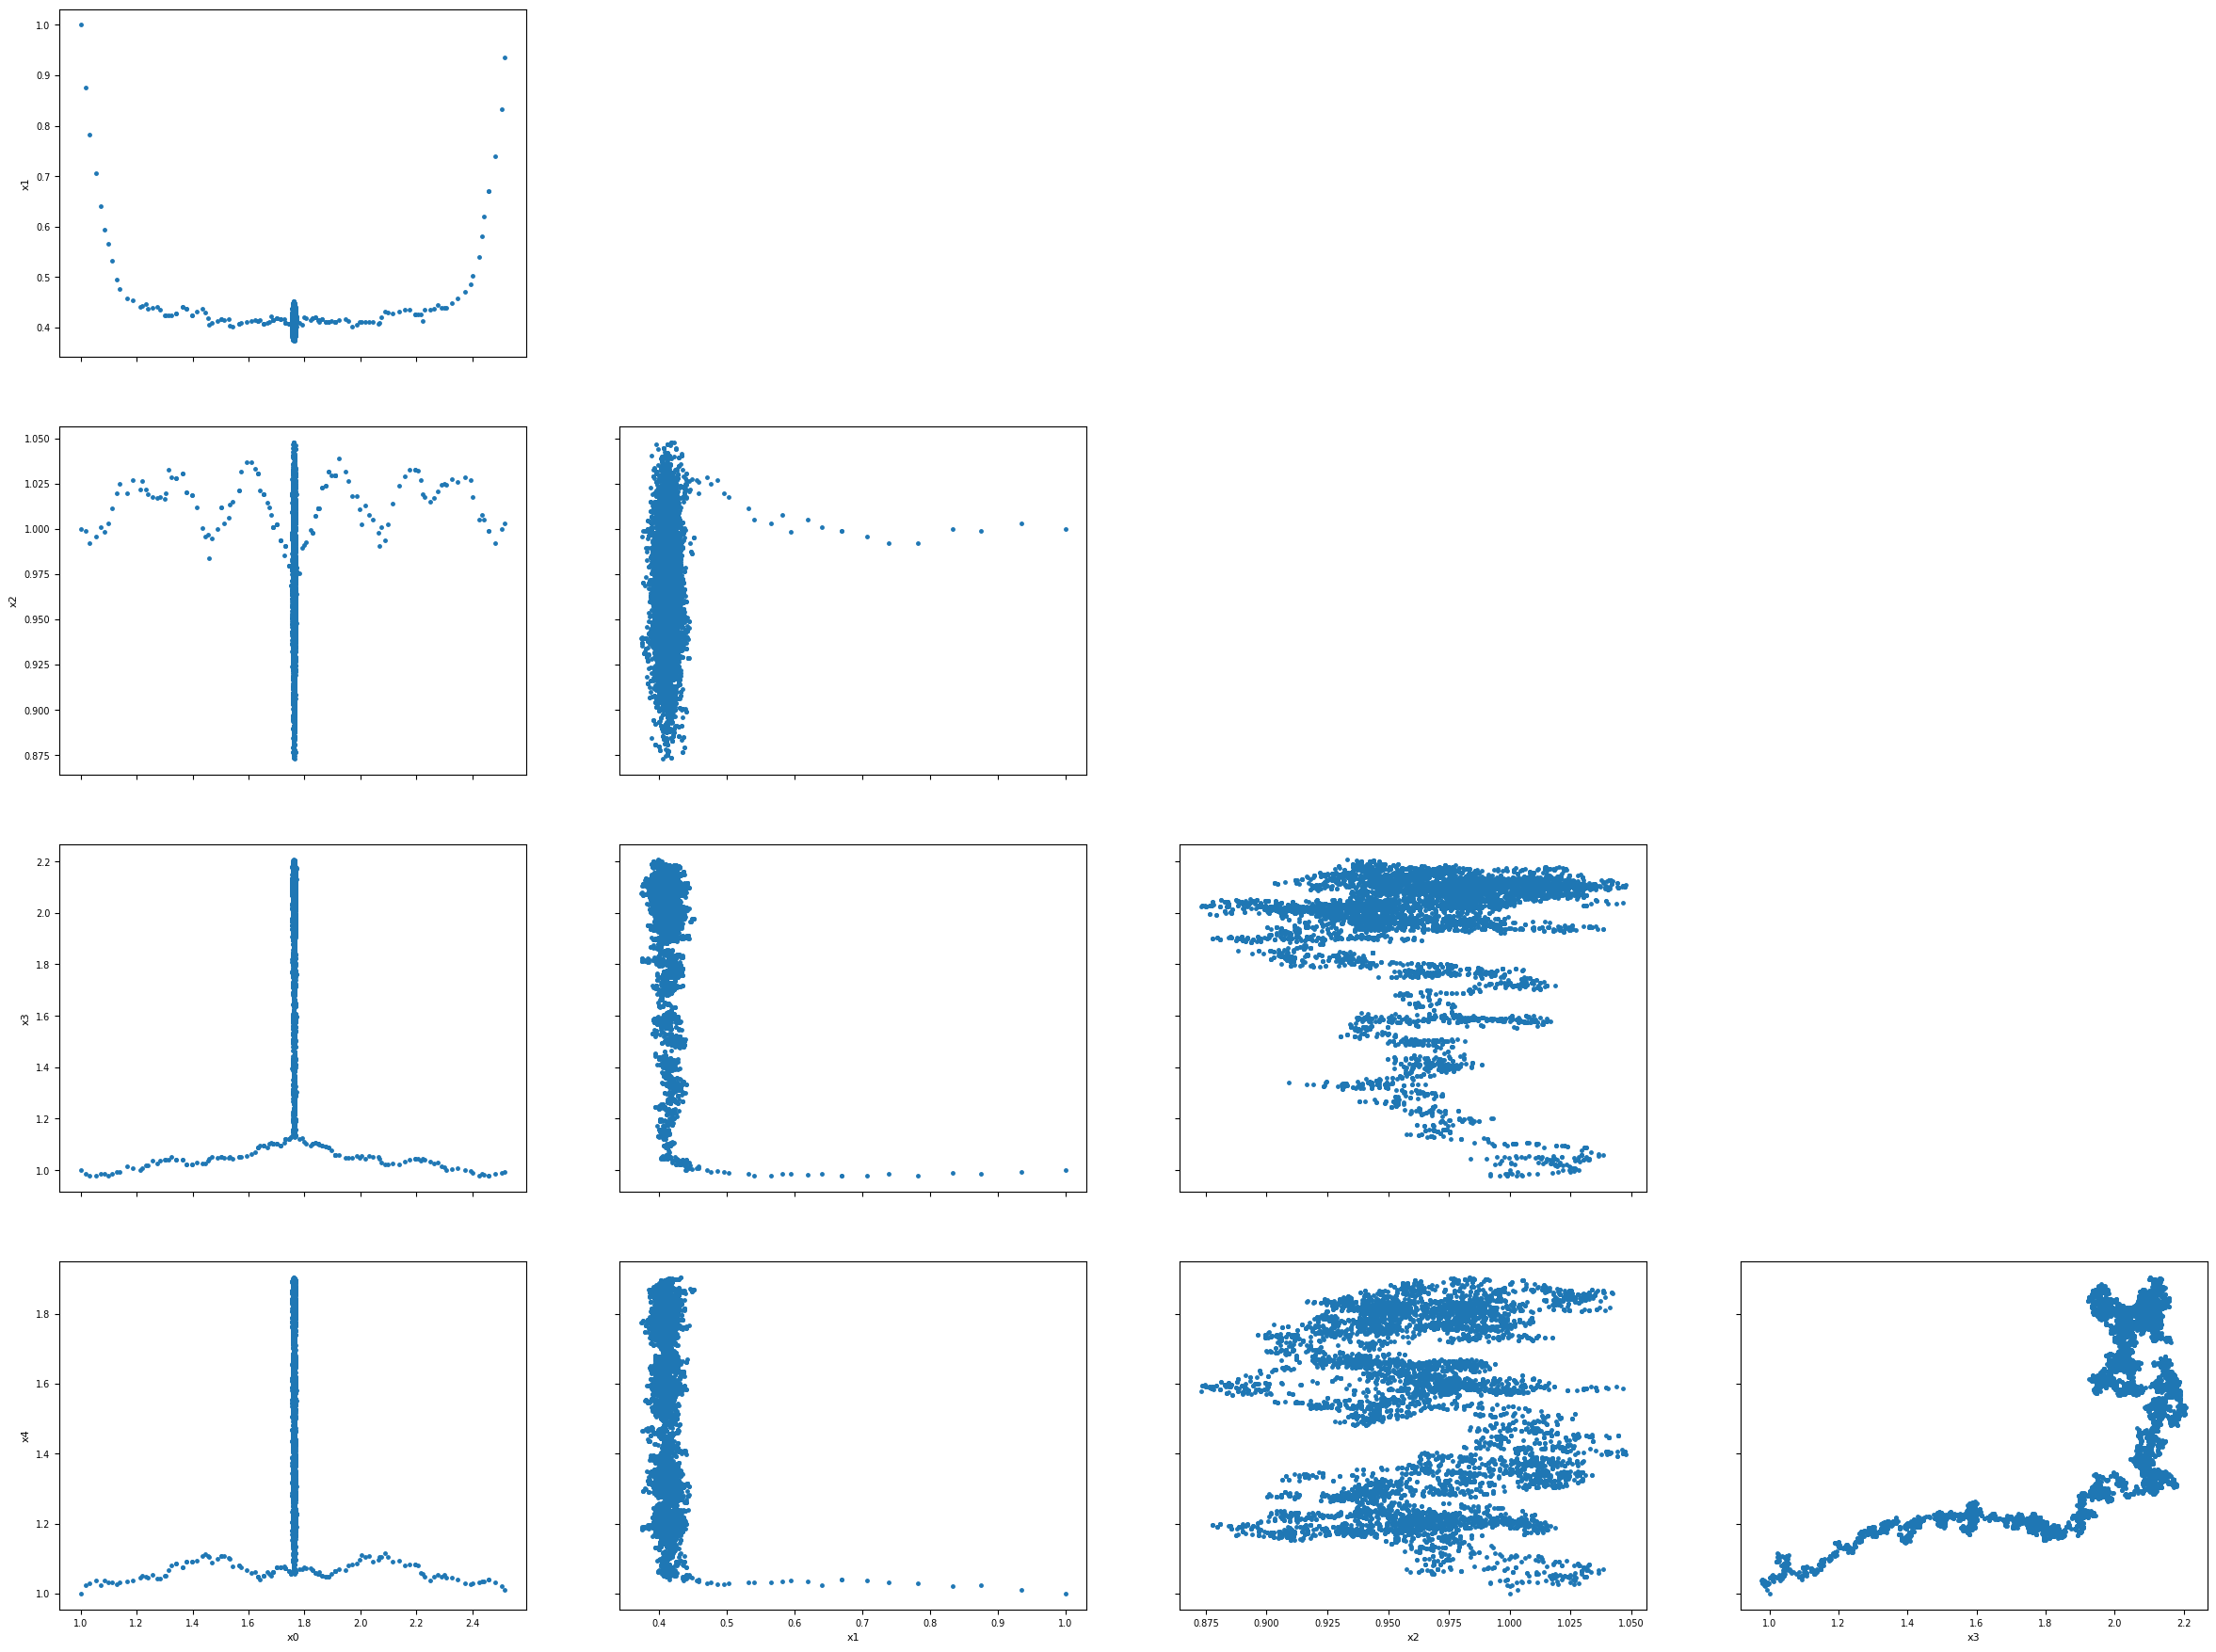

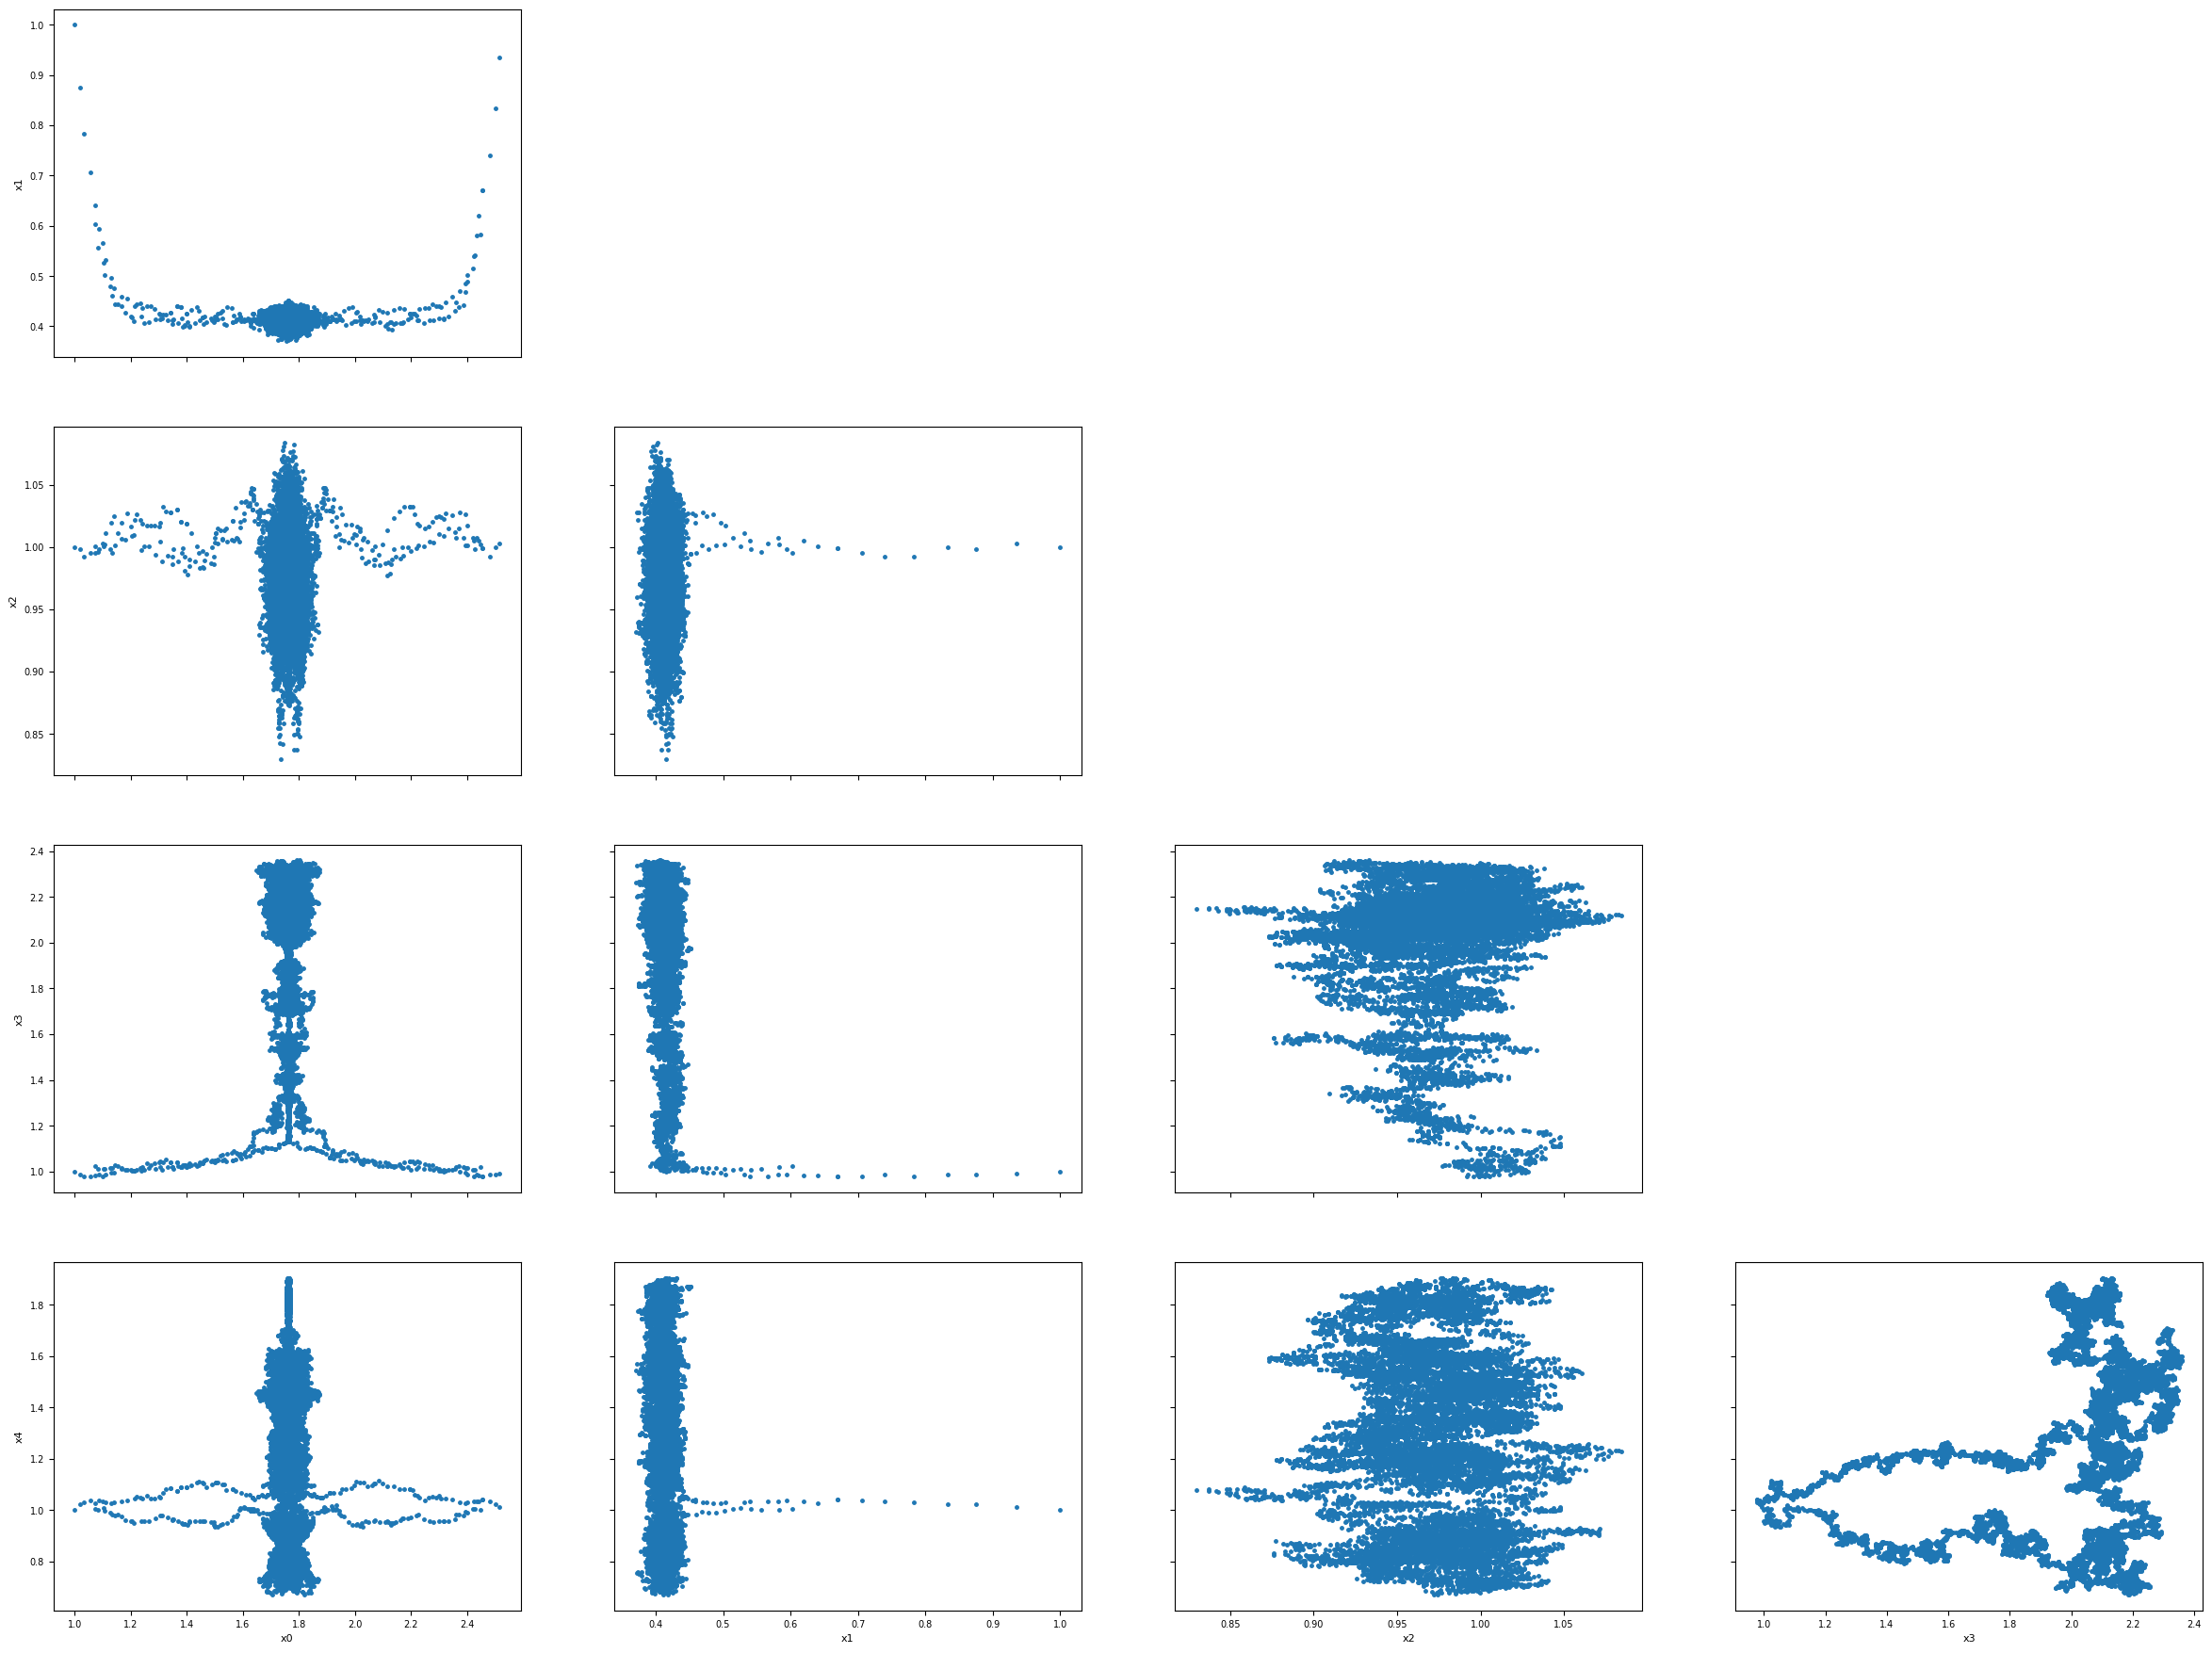

In [ ]:
# Visualize/Analyze the combined samples, cont.
posterior_samples.plot_pair([0,1,2,3,4])
pcn_samples.plot_pair([0,1,2,3,4])
combined_samples.plot_pair([0,1,2,3,4])

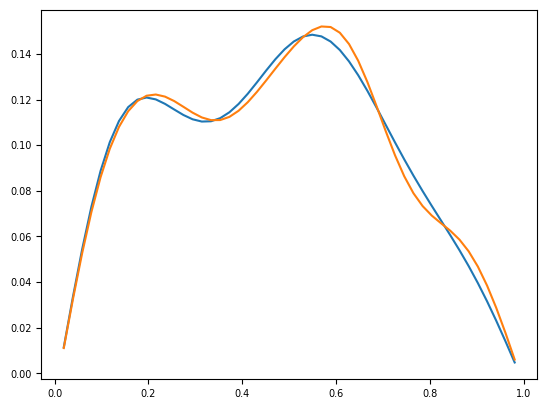

In [ ]:
# Compute the MAP point
maximizer = cuqi.solver.maximize(posterior.logpdf, np.zeros(domain_geometry.par_dim))
sol = maximizer.solve()
plt.plot(grid, domain_geometry.par2fun(sol[0]))
x_exact.plot()

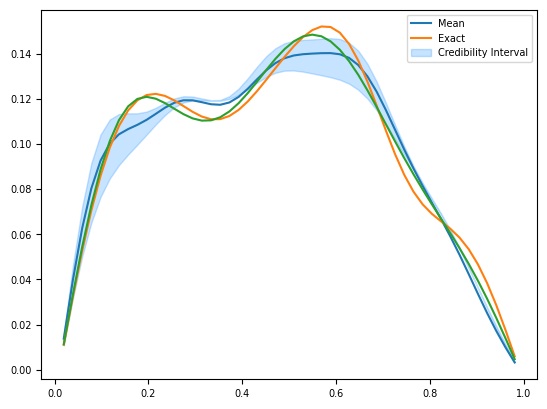

In [ ]:
# Plot the posterior ci and MAP point
posterior_samples.plot_ci(95, exact=x_exact)
plt.plot(grid, domain_geometry.par2fun(sol[0]))

In [ ]:
# Test that the factor 1/sqrt(N) is required to normalize the error vector.
norms = []
for i in range(100):
    norms.append(np.linalg.norm(np.random.randn(i))/np.sqrt(i))
norms

/var/folders/rr/13wqhtdj7bx5n5j3bfdhsz5r0000gn/T/ipykernel_94869/20277599.py:4: RuntimeWarning: invalid value encountered in double_scalars
  norms.append(np.linalg.norm(np.random.randn(i))/np.sqrt(i))


[nan,
 0.3161497508620733,
 0.9546141993856884,
 0.5923882156917893,
 1.0304364299723718,
 1.1277290558756692,
 0.6921251761304307,
 0.7374626918265386,
 1.2033404090666413,
 0.7009669045428194,
 0.9897632699237437,
 0.9254571745472019,
 0.991097935504832,
 0.982605898110069,
 1.146771573720597,
 0.8904466206843271,
 0.928764754543649,
 1.3501829303450477,
 0.9634528511359254,
 1.1033082516792692,
 0.9770476753516415,
 1.1612731981267608,
 1.1056450963593343,
 0.955796407197282,
 1.1665274553844132,
 1.1101921929152971,
 1.1433109967100918,
 0.9285737891059886,
 1.1352163424379245,
 1.3919995478020215,
 1.0580470536133775,
 0.9598252544494535,
 0.7467073740876845,
 0.9930080645327868,
 0.9451587898664222,
 1.080805624086114,
 1.0717182102990068,
 0.8003666746988013,
 1.1277216721907828,
 1.1674160132015128,
 1.139763483795501,
 0.8687051272978532,
 1.1440279700581486,
 1.0678439154111028,
 1.1428553473474001,
 0.9240760687441572,
 0.8837472479705322,
 0.8957747354149841,
 1.02127544180

# Code for figures:

NotImplementedError: fun2par not implemented. 

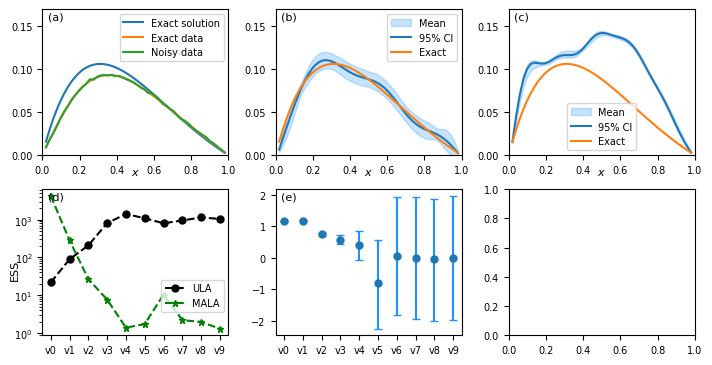

In [444]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig_posterior_samples = posterior_samples.burnthin(1000)
fig_pcn_samples = pcn_samples.burnthin(1000)


cm_to_in = 1/2.54
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(17.8*cm_to_in, 9*cm_to_in),
                        layout="constrained")

plt.sca(axs[0,0])
plt.annotate('(a)', xy=(0.03, 0.93), xycoords='axes fraction')
x_exact.plot()
y_exact.plot()
data.plot()
plt.legend(['Exact solution', 'Exact data', 'Noisy data']);
plt.ylim([0,0.17])
plt.yticks([0,0.05,0.1,0.15])
plt.xlim([0,1])
#plt.ylabel('$g(x)$')
plt.xlabel('$x$')
plt.gca().xaxis.set_label_coords(0.5, -0.08)

plt.sca(axs[0,1])
plt.annotate('(b)', xy=(0.03, 0.93), xycoords='axes fraction')
lci = fig_posterior_samples.funvals.plot_ci(95, plot_par=False, exact=x_exact)
lci[0].set_label("95% CI")
lci[1].set_label("Exact")
lci[2].set_label("Mean")
plt.legend()
plt.ylim([0,0.17])
plt.yticks([0,0.05,0.1,0.15])
plt.xlim([0,1])
plt.xlabel('$x$')
plt.gca().xaxis.set_label_coords(0.5, -0.08)


plt.sca(axs[0,2])
plt.annotate('(c)', xy=(0.03, 0.93), xycoords='axes fraction')
lci = fig_pcn_samples.funvals.plot_ci(95, plot_par=False, exact=x_exact)
lci[0].set_label("95% CI")
lci[1].set_label("Exact")
lci[2].set_label("Mean")
plt.legend()
plt.ylim([0,0.17])
plt.yticks([0,0.05,0.1,0.15])
plt.xlim([0,1])
plt.xlabel('$x$')
plt.gca().xaxis.set_label_coords(0.5, -0.08)


plt.rc('lines', markersize=SMALL_SIZE-2) 
plt.sca(axs[1,0])
plt.semilogy(fig_posterior_samples.compute_ess(), 'ko--', label='ULA') #CWMH
plt.semilogy(fig_pcn_samples.compute_ess(), '*--', label='MALA', color='green') #PCN
plt.annotate('(d)', xy=(0.03, 0.93), xycoords='axes fraction')
plt.legend(loc='center right', bbox_to_anchor=(1., 0.27))
plt.ylabel('ESS')
plt.gca().yaxis.set_label_coords(-0.12, 0.45) #-0.12, 0.4
plt.xticks(range(domain_geometry.num_modes))
plt.gca().set_xticklabels(['v{}'.format(i) for i in range(domain_geometry.num_modes)])



plt.sca(axs[1,1])
plt.annotate('(e)', xy=(0.03, 0.93), xycoords='axes fraction')
lci = fig_posterior_samples.plot_ci(95, plot_par=True, exact=x_exact)
lci[0].set_label("95% CI")
lci[1].set_label("Exact")
lci[2].set_label("Mean")
plt.legend(loc='lower left')


plt.sca(axs[1,2])
plt.annotate('(f)', xy=(0.03, 0.93), xycoords='axes fraction')
lci = fig_pcn_samples.plot_ci(95, plot_par=True, exact=x_exact)
lci[0].set_label("95% CI")
lci[1].set_label("Exact")
lci[2].set_label("Mean")
plt.legend()


fig.tight_layout(pad=0, w_pad=0.1, h_pad=0.9)
plt.savefig('figs/fig2.pdf', bbox_inches='tight', pad_inches=0.01, dpi=1200)





<Figure size 640x480 with 0 Axes>

In [ ]:
fig.get_size_inches()/cm_to_in

array([17.8,  9. ])

In [ ]:
plt.imshow?

Signature:
plt.imshow(
    X,
    cmap=None,
    norm=None,
    *,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    interpolation_stage=None,
    filternorm=True,
    filterrad=4.0,
    resample=None,
    url=None,
    data=None,
    **kwargs,
)
Docstring:
Display data as an image, i.e., on a 2D regular raster.

The input may either be actual RGB(A) data, or 2D scalar data, which
will be rendered as a pseudocolor image. For displaying a grayscale
image set up the colormapping using the parameters
``cmap='gray', vmin=0, vmax=255``.

The number of pixels used to render an image is set by the Axes size
and the *dpi* of the figure. This can lead to aliasing artifacts when
the image is resampled because the displayed image size will usually
not match the size of *X* (see
:doc:`/gallery/images_contours_and_fields/image_antialiasing`).
The resampling can be controlled via the *interpolation* parameter
and/or :rc:`imag

In [ ]:
le

In [ ]:
lm

In [ ]:
lc

In [ ]:
lm, le, lc

In [ ]:

geom= cuqi.geometry.Continuous2D((2,2))
s = cuqi.samples.Samples(np.random.randn(4, 100), geometry=geom)

im_mn, im_ex, im_lo, im_up, im_wd = s.plot_ci(95, plot_par=False, exact=geom.par2fun(np.random.randn(4)))



In [ ]:
lc

In [ ]:
lm

In [ ]:
matplotlib.collections.PolyCollection
matplotlib.lines.Line2D
ErrorbarContainer

2D (All)
matplotlib.collections.PolyCollection

matplotlib.artist.Artist

In [ ]:
im_wd


In [ ]:
model = cuqi.testproblem.Heat_1D(dim = 30).model
def g(x, dir):
    return cuqi.utilities.approx_derivative(model, x, dir)

model._gradient_func = g

x = cuqi.distribution.GaussianCov(np.zeros(30), 1)
y = cuqi.distribution.GaussianCov(model(x), np.eye(30)*.01)
y_obs = y.sample()

posterior = cuqi.distribution.Posterior(y.to_likelihood(y_obs), x)

ULA_sampler = cuqi.sampler.ULA(posterior, 1/30)
ULA_samples = ULA_sampler.sample_adapt(1000)




In [ ]:
#cuqi.utilities.approx_derivative?
cuqi.distribution.Posterior?

In [445]:
geom = cuqi.geometry.Continuous1D(30)
z = cuqi.samples.CUQIarray(np.random.randn(30), geometry=geom)

w = np.ndarray(z.shape)

In [446]:
z_nd = z.view(np.ndarray)

In [447]:
z_nd

array([-1.17040063,  1.43523115, -0.8751036 ,  0.49179086,  0.95425157,
        0.08921684, -0.96382418,  0.11168064, -1.3289928 ,  0.20455368,
       -1.48825619,  0.28824882,  0.65184226,  0.01959177, -1.19791851,
        0.27262073, -0.83156621, -0.81087223, -0.69980175, -0.62226527,
       -0.86873594, -0.0414109 ,  0.86834012, -0.70009923, -0.10866432,
        0.41174056,  0.59971286, -1.39370248, -1.75754801, -0.2174228 ])

In [ ]:
w[:]=z

In [448]:
z

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Continuous1D(30,)

Parameters:
 True

Array:
CUQIarray([-1.17040063,  1.43523115, -0.8751036 ,  0.49179086,
            0.95425157,  0.08921684, -0.96382418,  0.11168064,
           -1.3289928 ,  0.20455368, -1.48825619,  0.28824882,
            0.65184226,  0.01959177, -1.19791851,  0.27262073,
           -0.83156621, -0.81087223, -0.69980175, -0.62226527,
           -0.86873594, -0.0414109 ,  0.86834012, -0.70009923,
           -0.10866432,  0.41174056,  0.59971286, -1.39370248,
           -1.75754801, -0.2174228 ])

In [ ]:
w

In [ ]:

import numpy as np
from scipy.stats import chi2
from scipy.special import gammaln


def fminESS(p, alpha=.05, eps=.05, ess=None):
    """
    Minimum effective sample size
    """

    crit = chi2.ppf(1 - alpha, p)
    foo = 2. / p

    if ess is None:
        logminESS = foo * np.log(2.) + np.log(np.pi) - foo * np.log(p) -\
            foo * gammaln(p / 2.) - 2. * np.log(eps) + np.log(crit)
        return np.round(np.exp(logminESS))
    else:
        if isinstance(ess, str):
            raise ValueError("Only numeric entry allowed for ess")
        logEPS = .5 * foo * np.log(2.) + .5 * np.log(np.pi) -\
            .5 * foo * np.log(p) - .5 * foo * gammaln(p / 2.) -\
            .5 * np.log(ess) + .5 * np.log(crit)
        return np.exp(logEPS)


def multiESS(X, b='sqroot', Noffsets=10, Nb=None):
    """
    Compute multivariate effective sample size of a single Markov chain X,
    using the multivariate dependence structure of the process.

    X: MCMC samples of shape (n, p)
    n: number of samples
    p: number of parameters

    b: specifies the batch size for estimation of the covariance matrix in
       Markov chain CLT. It can take a numeric value between 1 and n/2, or a
       char value between:

    'sqroot'    b=floor(n^(1/2)) (for chains with slow mixing time; default)
    'cuberoot'  b=floor(n^(1/3)) (for chains with fast mixing time)
    'lESS'      pick the b that produces the lowest effective sample size
                for a number of b ranging from n^(1/4) to n/max(20,p); this
                is a conservative choice

    If n is not divisible by b Sigma is recomputed for up to Noffsets subsets
    of the data with different offsets, and the output mESS is the average over
    the effective sample sizes obtained for different offsets.

    Nb specifies the number of values of b to test when b='less'
    (default NB=200). This option is unused for other choices of b.

    Original source: https://github.com/lacerbi/multiESS

    Reference:
    Vats, D., Flegal, J. M., & Jones, G. L. "Multivariate Output Analysis
    for Markov chain Monte Carlo", arXiv preprint arXiv:1512.07713 (2015).

    """

    # MCMC samples and parameters
    n, p = X.shape

    if p > n:
        raise ValueError(
            "More dimensions than data points, cannot compute effective "
            "sample size.")

    # Input check for batch size B
    if isinstance(b, str):
        if b not in ['sqroot', 'cuberoot', 'less']:
            raise ValueError(
                "Unknown string for batch size. Allowed arguments are "
                "'sqroot', 'cuberoot' and 'lESS'.")
        if b != 'less' and Nb is not None:
            raise Warning(
                "Nonempty parameter NB will be ignored (NB is used "
                "only with 'lESS' batch size B).")
    else:
        if not 1. < b < (n / 2):
            raise ValueError(
                "The batch size B needs to be between 1 and N/2.")

    # Compute multiESS for the chain
    mESS = multiESS_chain(X, n, p, b, Noffsets, Nb)

    return mESS


def multiESS_chain(Xi, n, p, b, Noffsets, Nb):
    """
    Compute multiESS for a MCMC chain.
    """

    if b == 'sqroot':
        b = [int(np.floor(n ** (1. / 2)))]
    elif b == 'cuberoot':
        b = [int(np.floor(n ** (1. / 3)))]
    elif b == 'less':
        b_min = np.floor(n ** (1. / 4))
        b_max = max(np.floor(n / max(p, 20)), np.floor(np.sqrt(n)))
        if Nb is None:
            Nb = 200
        # Try NB log-spaced values of B from B_MIN to B_MAX
        b = set(map(int, np.round(np.exp(
            np.linspace(np.log(b_min), np.log(b_max), Nb)))))

    # Sample mean
    theta = np.mean(Xi, axis=0)
    # Determinant of sample covariance matrix
    if p == 1:
        detLambda = np.cov(Xi.T)
    else:
        detLambda = np.linalg.det(np.cov(Xi.T))

    # Compute mESS
    mESS_i = []
    for bi in b:
        mESS_i.append(multiESS_batch(Xi, n, p, theta, detLambda, bi, Noffsets))
    # Return lowest mESS
    mESS = np.min(mESS_i)

    return mESS


def multiESS_batch(Xi, n, p, theta, detLambda, b, Noffsets):
    """
    Compute multiESS for a given batch size B.
    """

    # Compute batch estimator for SIGMA
    a = int(np.floor(n / b))
    Sigma = np.zeros((p, p))
    offsets = np.sort(list(set(map(int, np.round(
        np.linspace(0, n - np.dot(a, b), Noffsets))))))

    for j in offsets:
        # Swapped a, b in reshape compared to the original code.
        Y = Xi[j + np.arange(a * b), :].reshape((a, b, p))
        Ybar = np.squeeze(np.mean(Y, axis=1))
        Z = Ybar - theta
        for i in range(a):
            if p == 1:
                Sigma += Z[i] ** 2
            else:
                Sigma += Z[i][np.newaxis, :].T * Z[i]

    Sigma = (Sigma * b) / (a - 1) / len(offsets)
    mESS = n * (detLambda / np.linalg.det(Sigma)) ** (1. / p)

    return mESS


def main():
    """
    Test against the original code. Requires Octave and oct2py installed, and
    the original 'multiESS.m' file in the dir.
    """

    from oct2py import octave
    nchains = np.random.randint(2, 10)
    print("Chains: ", nchains)
    for k in range(nchains):

        nruns = np.random.randint(100, 20000)
        nparams = np.random.randint(1, 7)

        samples_chains = np.random.uniform(0., 1., (nchains, nruns, nparams))
        chain = samples_chains[k]

        print("N, p: ", nruns, nparams)
        mESS_python = multiESS(chain, b="sqroot")
        #mESS_matlab = octave.multiESS(chain, [], "sqroot")

        print("mESS_py, mESS_ml: {:.2f} {:.2f}".format(
            mESS_python, mESS_python))


if __name__ == '__main__':
    #main()
    print(multiESS(fig_pcn_samples.samples.T, b='less', Noffsets=10, Nb=None))
    print(multiESS(fig_posterior_samples.samples.T, b='less', Noffsets=10, Nb=None))  
    #print(fminESS(posterior_samples.samples.T, alpha=.05, eps=.05, ess=None))

63.8255412027993
119.10989460170566


mESS pCN = 100, 100,000

mESS CWMH = 760, 10,000

mESS MALA = 63, 10,000 #96 # No adaptation

mESS ULA = 119, 10,000 # No adaptation

NUTS: bug

ESS 